In [558]:
import pandas as pd
import torch
import os
from umap import UMAP
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sksurv.linear_model import CoxPHSurvivalAnalysis
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.linear_model import LogisticRegression
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index

In [560]:
foundation = '/workspace/radraid/projects/imaging_biomarker/CLIP_nodule/results_downstream/foundation'
clip = '/workspace/radraid/projects/imaging_biomarker/CLIP_nodule/results_downstream/bz4_j10_lr1e-05_wd0.001_pd256_dropout0.1_epochs100_ga1_general_internal_external_freeze'

In [561]:
abnorm = pd.read_csv('/workspace/radraid/projects/longitudinal_lung/characterization/cleaned_csv/cleaned_semantic.csv')[['pid','nodule_id','level_of_suspicion_of_lung_cancer']]

In [562]:
semantic = pd.read_csv('/workspace/radraid/projects/imaging_biomarker/CLIP_nodule/dataset_csv/semantic_label.csv')
semantic = semantic.merge(abnorm, on = ['pid','nodule_id'], how = 'left')
semantic = semantic.sort_values(['pid','nodule_id','level_of_suspicion_of_lung_cancer'], ascending = [True, True, False]).drop_duplicates('pid').reset_index(drop = True)
semantic['time'] = semantic.screen_to_days
semantic['status'] = 1- semantic.censorship
semantic['diagnosis_1'] = ((semantic.status==1) & (semantic.time<=365 )).astype(int)


# Foundation model result

In [563]:
#nlst feature
f_feat=[]
for i, row in semantic.iterrows():
    pid = str(int(row.pid))
    nodule_id = str(int(row.nodule_id))
    feat = torch.load(os.path.join(foundation,f'{pid}_{nodule_id}.pt'))
    f_feat.append(feat.squeeze())
f_feat = torch.stack(f_feat).detach().cpu().numpy()
f_feat.shape

(899, 4096)

In [621]:
#ucla feature
f_feat_ucla=[]
ucla_data = pd.read_csv('/workspace/radraid/projects/imaging_biomarker/CLIP_nodule/dataset_csv/ucla_path_label.csv')
for i, row in ucla_data.iterrows():
    pid = row.pid
    feat = torch.load(os.path.join(foundation,f'{pid}.pt'))
    f_feat_ucla.append(feat.squeeze())
f_feat_ucla = torch.stack(f_feat_ucla).detach().cpu().numpy()


In [622]:
#train val splits
splits = np.load('/workspace/radraid/projects/imaging_biomarker/CLIP_nodule/splits.npz')
train_pid = splits['train_pid']
val_pid = splits['val_pid']

train_ind =semantic[semantic.pid.isin(train_pid)].index
val_ind  =semantic[semantic.pid.isin(val_pid)].index

In [623]:
#data = pd.concat([semantic[['time', 'status']],pd.DataFrame(f_feat)],axis =1)
#train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)
#features = data.columns.drop(['time', 'status'])
#X_train = train_data[features]
#X_val = val_data[features]

#y_train = np.array(list(zip(train_data['status'].astype(bool), train_data['time'])), dtype=[('status', bool), ('time', float)])
#y_val = np.array(list(zip(val_data['status'].astype(bool), val_data['time'])), dtype=[('status', bool), ('time', float)])

In [624]:
#X_train, X_test, y_train, y_test = train_test_split(pd.DataFrame(f_feat), semantic['diagnosis_1'].values, test_size=0.2, random_state=42, stratify = semantic['diagnosis_1'].values)
X_train = pd.DataFrame(f_feat).loc[train_ind,:]
X_val = pd.DataFrame(f_feat).loc[val_ind,:]
y_train = semantic['diagnosis_1'].values[train_ind]
y_val = semantic['diagnosis_1'].values[val_ind]
y_test = ucla_data['diagnosis'].values

In [625]:
#scale feature
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(f_feat_ucla)

In [626]:
'''
pca_c = PCA(n_components=256)
pca_c.fit(X_train)
X_train_256 = pca_c.transform(X_train)
X_val_256 = pca_c.transform(X_val)
X_test_256 = pca_c.transform(X_test)
'''

### Logistic Regression

In [628]:
model = LogisticRegression(penalty='l1', solver='liblinear', C = 0.1)
model.fit(X_train, y_train)
y_pred_prob = model.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred_prob)
auprc = average_precision_score(y_val, y_pred_prob)
print("AUC:", auc, "AUPRC:", auprc)

y_pred_prob = model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_prob)
auprc = average_precision_score(y_test, y_pred_prob)
print("AUC:", auc, "AUPRC:", auprc)


AUC: 0.8817642698295034 AUPRC: 0.6757455284167208
AUC: 0.5363984674329503 AUPRC: 0.5817841944690838


### Cox Model

In [629]:

X_train_pca = X_train[:,(model.coef_!=0)[0]]
X_val_pca = X_val[:,(model.coef_!=0)[0]]

y_train = np.array(list(zip(semantic['status'].values[train_ind].astype(bool), semantic['time'].values[train_ind])), dtype=[('status', bool), ('time', float)])
y_val = np.array(list(zip(semantic['status'].values[val_ind].astype(bool), semantic['time'].values[val_ind])), dtype=[('status', bool), ('time', float)])

cox_model = CoxPHSurvivalAnalysis()
cox_model.fit(X_train_pca, y_train)
c_index_train = cox_model.score(X_train_pca, y_train)
c_index_val = cox_model.score(X_val_pca, y_val)


risk_scores = cox_model.predict(X_val_pca)
risk_scores_array = np.exp(risk_scores)
print("Concordance Index on Training Set:", c_index_train)
print("Concordance Index on Validation Set:", c_index_val)


#cph = CoxPHFitter()
#cph.fit(pd.concat([pd.DataFrame(X_train_pca),semantic.loc[train_ind, ['status','time']].reset_index(drop = True)], axis =1), duration_col='time', event_col='status')
#c_index = cph.score( pd.concat([pd.DataFrame(X_val_pca),semantic.loc[val_ind, ['status','time']].reset_index(drop = True)], axis =1),
#          scoring_method="concordance_index")

#print("Concordance Index (C-index) on Train Set:", cph.concordance_index_)
#print("Concordance Index (C-index) on Test Set:", c_index)

Concordance Index on Training Set: 0.900725239646434
Concordance Index on Validation Set: 0.7928528164748637


In [637]:
'''
from sksurv.nonparametric import kaplan_meier_estimator
status = semantic['status'].values[val_ind].astype(bool)
time = semantic['time'].values[val_ind]

x, y, conf_int = kaplan_meier_estimator(status[risk_scores_array>3],time[risk_scores_array>3] , conf_type="log-log")
plt.step(x, y, where="post")
plt.fill_between(x, conf_int[0], conf_int[1], alpha=0.25, step="post")
x, y, conf_int = kaplan_meier_estimator(status[risk_scores_array<3],time[risk_scores_array<3] , conf_type="log-log")
plt.step(x, y, where="post")
plt.fill_between(x, conf_int[0], conf_int[1], alpha=0.25, step="post")
plt.ylim(0, 1)
plt.show()
'''

'\nfrom sksurv.nonparametric import kaplan_meier_estimator\nstatus = semantic[\'status\'].values[val_ind].astype(bool)\ntime = semantic[\'time\'].values[val_ind]\n\nx, y, conf_int = kaplan_meier_estimator(status[risk_scores_array>3],time[risk_scores_array>3] , conf_type="log-log")\nplt.step(x, y, where="post")\nplt.fill_between(x, conf_int[0], conf_int[1], alpha=0.25, step="post")\nx, y, conf_int = kaplan_meier_estimator(status[risk_scores_array<3],time[risk_scores_array<3] , conf_type="log-log")\nplt.step(x, y, where="post")\nplt.fill_between(x, conf_int[0], conf_int[1], alpha=0.25, step="post")\nplt.ylim(0, 1)\nplt.show()\n'

### UMAP

In [603]:
# Initialize UMAP and fit-transform the data
umap = UMAP(n_components=2)
umap_data = umap.fit_transform(X_val)
umap_data_test = umap.fit_transform(X_test)
#pca = PCA(n_components=2)
#pca.fit(X_train)
#pca_data = pca.transform(X_val)

# Plot the UMAP embeddings
y_diag = semantic['diagnosis_1'].values[val_ind]
plt.figure(figsize=(5, 5))
plt.scatter(umap_data[y_diag==1, 0], umap_data[y_diag==1, 1], c= ['red'] * np.sum(y_diag==1) ,  s=10, label='Malignant')
plt.scatter(umap_data[y_diag==0, 0], umap_data[y_diag==0, 1], c= ['blue'] * np.sum(y_diag==0),  s=10, label='Benign')
plt.title('UMAP Visualization of Features Extracted from Foundation Model (Val)')
plt.legend()
plt.show()


plt.figure(figsize=(5, 5))
plt.scatter(umap_data_test[y_test==1, 0], umap_data_test[y_test==1, 1], c= ['red'] * np.sum(y_test==1) ,  s=10, label='Malignant')
plt.scatter(umap_data_test[y_test==0, 0], umap_data_test[y_test==0, 1], c= ['blue'] * np.sum(y_test==0),  s=10, label='Benign')
plt.title('UMAP Visualization of Features Extracted from Foundation Model (UCLA)')
plt.legend()
plt.show()


KeyboardInterrupt



In [604]:
# Initialize UMAP and fit-transform the data
umap = UMAP(n_components=2)
umap_data_train = umap.fit_transform(X_train)
umap_data_val = umap.transform(X_val)
umap_data_test = umap.transform(X_test)


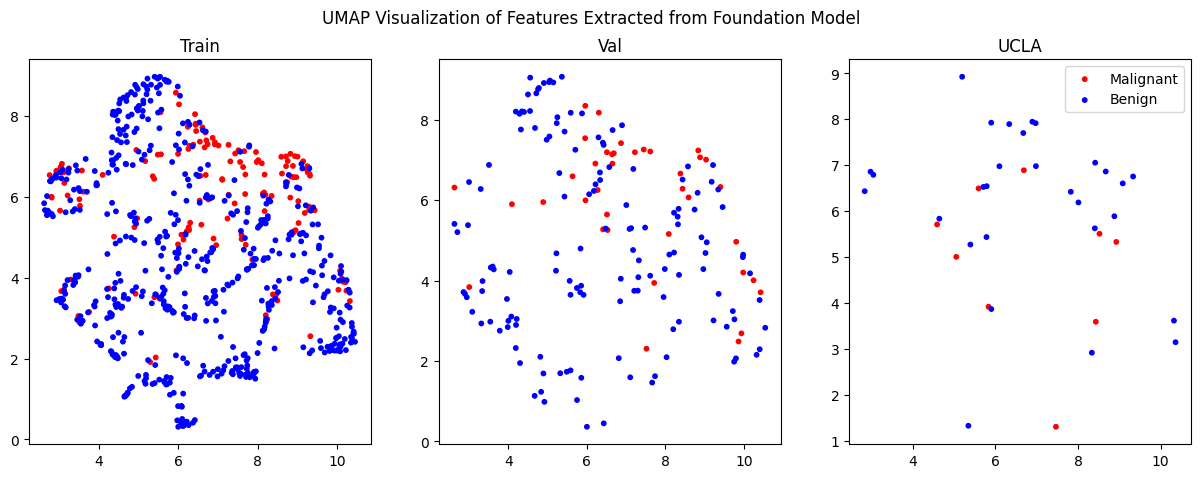

In [605]:

fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize = (15,5))

# Plot the UMAP embeddings
y_diag = semantic['diagnosis_1'].values[train_ind]
ax1.scatter(umap_data_train[y_diag==1, 0], umap_data_train[y_diag==1, 1], c= ['red'] * np.sum(y_diag==1) ,  s=10, label='Malignant')
ax1.scatter(umap_data_train[y_diag==0, 0], umap_data_train[y_diag==0, 1], c= ['blue'] * np.sum(y_diag==0),  s=10, label='Benign')
ax1.set_title('Train')

# Plot the UMAP embeddings
y_diag = semantic['diagnosis_1'].values[val_ind]
ax2.scatter(umap_data_val[y_diag==1, 0], umap_data_val[y_diag==1, 1], c= ['red'] * np.sum(y_diag==1) ,  s=10, label='Malignant')
ax2.scatter(umap_data_val[y_diag==0, 0], umap_data_val[y_diag==0, 1], c= ['blue'] * np.sum(y_diag==0),  s=10, label='Benign')
ax2.set_title('Val')


ax3.scatter(umap_data_test[y_test==1, 0], umap_data_test[y_test==1, 1], c= ['red'] * np.sum(y_test==1) ,  s=10, label='Malignant')
ax3.scatter(umap_data_test[y_test==0, 0], umap_data_test[y_test==0, 1], c= ['blue'] * np.sum(y_test==0),  s=10, label='Benign')
ax3.set_title('UCLA')

plt.suptitle('UMAP Visualization of Features Extracted from Foundation Model')
plt.legend()
plt.show()


# Contrastive learning result

In [630]:
c_feat=[]
for i, row in semantic.iterrows():
    pid = str(int(row.pid))
    nodule_id = str(int(row.nodule_id))
    feat = torch.load(os.path.join(clip,f'{pid}_{nodule_id}.pt'))
    c_feat.append(feat.squeeze())
c_feat = torch.stack(c_feat).detach().cpu().numpy()
c_feat.shape

(899, 256)

In [631]:
c_feat_ucla=[]
for i, row in ucla_data.iterrows():
    pid = row.pid
    feat = torch.load(os.path.join(clip,f'{pid}.pt'))
    c_feat_ucla.append(feat.squeeze())
c_feat_ucla = torch.stack(c_feat_ucla).detach().cpu().numpy()


In [632]:
X_train_c = pd.DataFrame(c_feat).loc[train_ind,:]
X_val_c = pd.DataFrame(c_feat).loc[val_ind,:]
y_train_c = semantic['diagnosis_1'].values[train_ind]
y_val_c = semantic['diagnosis_1'].values[val_ind]
y_test_c = ucla_data['diagnosis'].values

In [633]:
scaler_c = StandardScaler()
scaler_c.fit(X_train_c)

X_train_c = scaler_c.transform(X_train_c)
X_val_c = scaler_c.transform(X_val_c)
X_test_c = scaler_c.transform(c_feat_ucla)

### Logistic Regression

In [634]:
model_c = LogisticRegression(penalty='l1', solver='liblinear', C = 0.1)
model_c.fit(X_train_c, y_train_c)


y_pred_prob_c = model_c.predict_proba(X_val_c)[:, 1]
auc = roc_auc_score(y_val_c, y_pred_prob_c)
auprc = average_precision_score(y_val_c, y_pred_prob_c)
print("AUC:", auc, "AUPRC:", auprc)

y_pred_prob_c = model_c.predict_proba(X_test_c)[:, 1]
auc = roc_auc_score(y_test_c, y_pred_prob_c)
auprc = average_precision_score(y_test_c, y_pred_prob_c)
print("AUC:", auc, "AUPRC:", auprc)

AUC: 0.8604521868050407 AUPRC: 0.6950022107985052
AUC: 0.5887611749680716 AUPRC: 0.6185311542280996


### Cox Model

In [635]:

#print(n)
#pca_c = PCA(n_components=n)
#pca_c.fit(X_train_c)
#X_train_pca_c = pca_c.transform(X_train_c)
#X_val_pca_c = pca_c.transform(X_val_c)
X_train_pca_c = X_train_c[:,(model_c.coef_!=0)[0]]
X_val_pca_c = X_val_c[:,(model_c.coef_!=0)[0]]

y_train_c = np.array(list(zip(semantic['status'].values[train_ind].astype(bool), semantic['time'].values[train_ind])), dtype=[('status', bool), ('time', float)])
y_val_c = np.array(list(zip(semantic['status'].values[val_ind].astype(bool), semantic['time'].values[val_ind])), dtype=[('status', bool), ('time', float)])

cox_model_c = CoxPHSurvivalAnalysis()
cox_model_c.fit(X_train_pca_c, y_train_c)

c_index_train = cox_model_c.score(X_train_pca_c, y_train_c)
c_index_val = cox_model_c.score(X_val_pca_c, y_val_c)
print("Concordance Index on Training Set:", c_index_train)
print("Concordance Index on Validation Set:", c_index_val)

risk_scores_c = cox_model_c.predict(X_val_pca_c)
risk_scores_array_c = np.exp(risk_scores_c)

#cph = CoxPHFitter()
#cph.fit(pd.concat([pd.DataFrame(X_train_pca_c),semantic.loc[train_ind, ['status','time']].reset_index(drop = True)], axis =1), duration_col='time', event_col='status')
#c_index = cph.score( pd.concat([pd.DataFrame(X_val_pca_c),semantic.loc[val_ind, ['status','time']].reset_index(drop = True)], axis =1),
#          scoring_method="concordance_index")
#print("Concordance Index (C-index) on Train Set:", cph.concordance_index_)
#print("Concordance Index (C-index) on Test Set:", c_index)

Concordance Index on Training Set: 0.8810774989032734
Concordance Index on Validation Set: 0.8063294972743792


In [636]:
'''
from sksurv.nonparametric import kaplan_meier_estimator
status = semantic['status'].values[val_ind].astype(bool)
time = semantic['time'].values[val_ind]

x, y, conf_int = kaplan_meier_estimator(status[risk_scores_array_c>3],time[risk_scores_array_c>3] , conf_type="log-log")
plt.step(x, y, where="post")
plt.fill_between(x, conf_int[0], conf_int[1], alpha=0.25, step="post")
x, y, conf_int = kaplan_meier_estimator(status[risk_scores_array_c<3],time[risk_scores_array_c<3] , conf_type="log-log")
plt.step(x, y, where="post")
plt.fill_between(x, conf_int[0], conf_int[1], alpha=0.25, step="post")
plt.ylim(0, 1)
plt.show()

'''

'\nfrom sksurv.nonparametric import kaplan_meier_estimator\nstatus = semantic[\'status\'].values[val_ind].astype(bool)\ntime = semantic[\'time\'].values[val_ind]\n\nx, y, conf_int = kaplan_meier_estimator(status[risk_scores_array_c>3],time[risk_scores_array_c>3] , conf_type="log-log")\nplt.step(x, y, where="post")\nplt.fill_between(x, conf_int[0], conf_int[1], alpha=0.25, step="post")\nx, y, conf_int = kaplan_meier_estimator(status[risk_scores_array_c<3],time[risk_scores_array_c<3] , conf_type="log-log")\nplt.step(x, y, where="post")\nplt.fill_between(x, conf_int[0], conf_int[1], alpha=0.25, step="post")\nplt.ylim(0, 1)\nplt.show()\n\n'

### UMAP

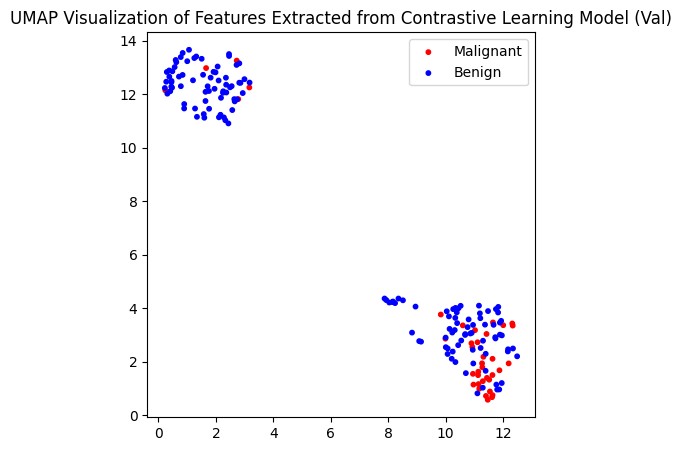

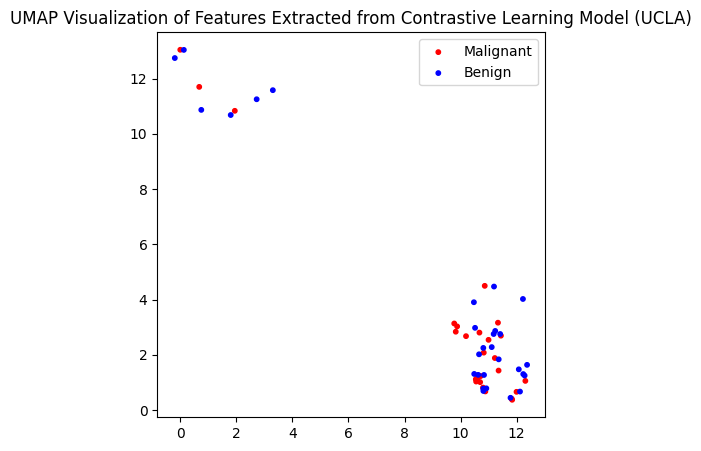

In [522]:
# Initialize UMAP and fit-transform the data
umap = UMAP(n_components=2)
umap_data = umap.fit_transform(X_val_c)
umap_data_test = umap.transform(X_test_c)


# Plot the UMAP embeddings
y_diag = semantic['diagnosis_1'].values[val_ind]
plt.figure(figsize=(5, 5))
plt.scatter(umap_data[y_diag==1, 0], umap_data[y_diag==1, 1], c= ['red'] * np.sum(y_diag==1) ,  s=10, label='Malignant')
plt.scatter(umap_data[y_diag==0, 0], umap_data[y_diag==0, 1], c= ['blue'] * np.sum(y_diag==0),  s=10, label='Benign')
plt.title('UMAP Visualization of Features Extracted from Contrastive Learning Model (Val)')
plt.legend()
plt.show()


plt.figure(figsize=(5, 5))
plt.scatter(umap_data_test[y_test==1, 0], umap_data_test[y_test==1, 1], c= ['red'] * np.sum(y_test==1) ,  s=10, label='Malignant')
plt.scatter(umap_data_test[y_test==0, 0], umap_data_test[y_test==0, 1], c= ['blue'] * np.sum(y_test==0),  s=10, label='Benign')
plt.title('UMAP Visualization of Features Extracted from Contrastive Learning Model (UCLA)')
plt.legend()
plt.show()


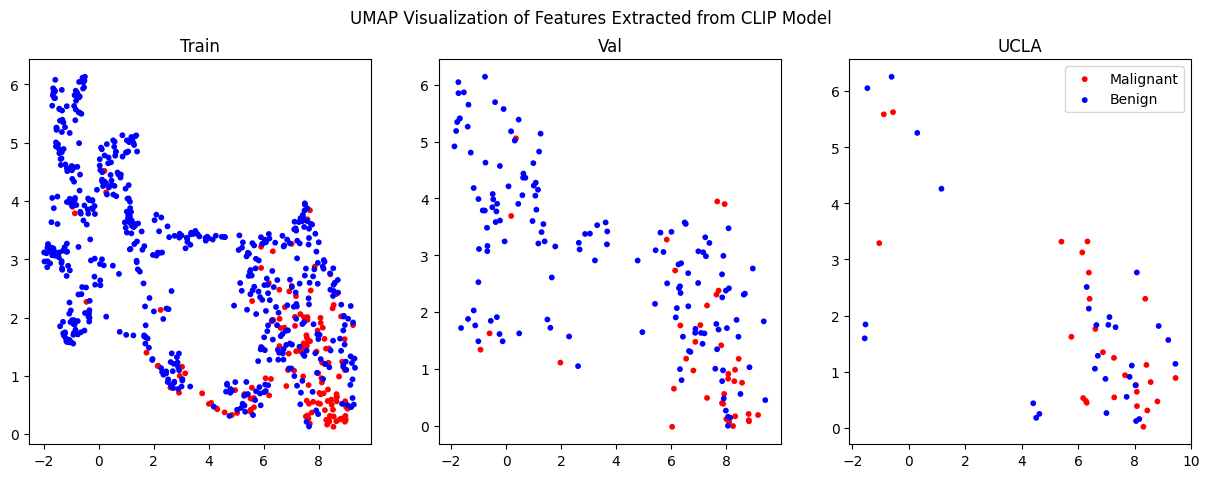

In [529]:
# Initialize UMAP and fit-transform the data
umap = UMAP(n_components=2)
umap_data_train = umap.fit_transform(X_train_c)
umap_data_val = umap.transform(X_val_c)
umap_data_test = umap.transform(X_test_c)


fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize = (15,5))

# Plot the UMAP embeddings
y_diag = semantic['diagnosis_1'].values[train_ind]
ax1.scatter(umap_data_train[y_diag==1, 0], umap_data_train[y_diag==1, 1], c= ['red'] * np.sum(y_diag==1) ,  s=10, label='Malignant')
ax1.scatter(umap_data_train[y_diag==0, 0], umap_data_train[y_diag==0, 1], c= ['blue'] * np.sum(y_diag==0),  s=10, label='Benign')
ax1.set_title('Train')

# Plot the UMAP embeddings
y_diag = semantic['diagnosis_1'].values[val_ind]
ax2.scatter(umap_data_val[y_diag==1, 0], umap_data_val[y_diag==1, 1], c= ['red'] * np.sum(y_diag==1) ,  s=10, label='Malignant')
ax2.scatter(umap_data_val[y_diag==0, 0], umap_data_val[y_diag==0, 1], c= ['blue'] * np.sum(y_diag==0),  s=10, label='Benign')
ax2.set_title('Val')


ax3.scatter(umap_data_test[y_test==1, 0], umap_data_test[y_test==1, 1], c= ['red'] * np.sum(y_test==1) ,  s=10, label='Malignant')
ax3.scatter(umap_data_test[y_test==0, 0], umap_data_test[y_test==0, 1], c= ['blue'] * np.sum(y_test==0),  s=10, label='Benign')
ax3.set_title('UCLA')

plt.suptitle('UMAP Visualization of Features Extracted from CLIP Model')
plt.legend()
plt.show()
